In the following markdown there is a full proj about predicting the machine failure for robotic parts.For these procedure we will need an EDA analysis using the *"robotics.csv"* file via on kaggle.

First import all the necessary libraries

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_csv("robotics.csv")
print("columns of dataset:", data.columns.tolist())

columns of dataset: ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


we obtain info for this dataset which are about :
* UDI 
* Product ID
* Type
* Air temperature [K]
* Process temperature [K]
* Rotational speed [rpm]
* Torque [Nm] 
* Tool wear [min]
* Machine failure
* TWF 
* HDF 
* PWF 
* OSF 
* RNF

Nextly , we split the dataset into 2 variables by the columns machine failure (either 1 or 0 for each occasion)
and we print how many machines are considered broken or fixed 


In [4]:
failures = data[data['Machine failure'] == 1]
success = data[data['Machine failure'] == 0]

print(f"Failures: {len(failures)}")
print(f"Successes: {len(success)}")

Failures: 339
Successes: 9661


# EDA analysis:
we check with a scatter plot what features would be possible causes why or when a machine is bound to get broken.
1) we use scatter plot to visualize the behaviour between features by their type o machine (H,M,L).

the following scatter plot show us how a machine is inluenced by its features *-* Rotational speed [rpm] and Torque (Nm)

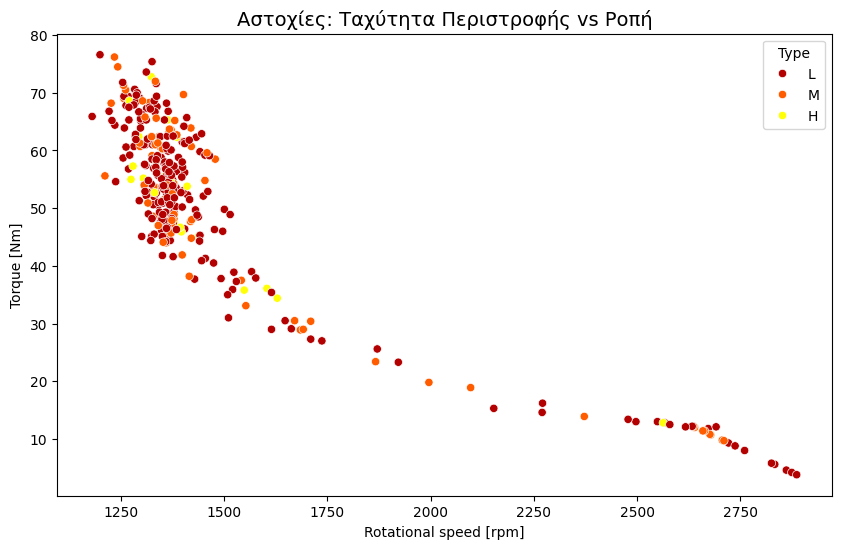

In [5]:
# Scatter plot only for the failure types
plt.figure(figsize=(10, 6))
sns.scatterplot(data=failures, x="Rotational speed [rpm]", y="Torque [Nm]", hue="Type", palette="hot")
plt.title("Αστοχίες: Ταχύτητα Περιστροφής vs Ροπή", fontsize=14)
plt.savefig("failures_scatter.png")

the basic info would be that a machine is prior to get broken if it has a high value on its torque while this forces the machine to lower its rpm's. If torque exceeds 50 Nm, especially if the speed is below 1400 rpm, that is where most failures occur statistically.

we can see those values by each type seperatelly

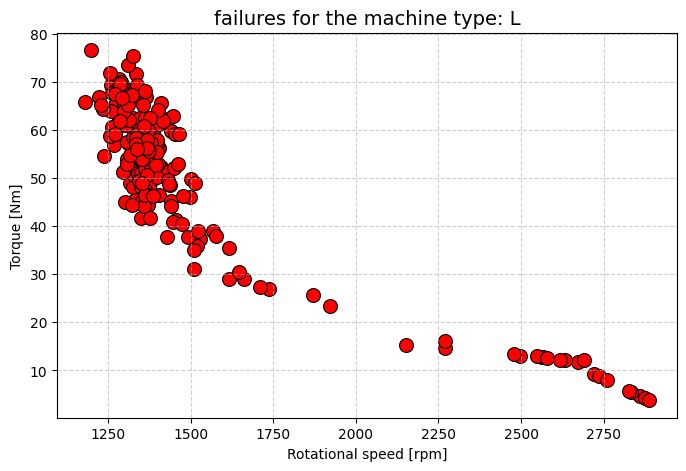

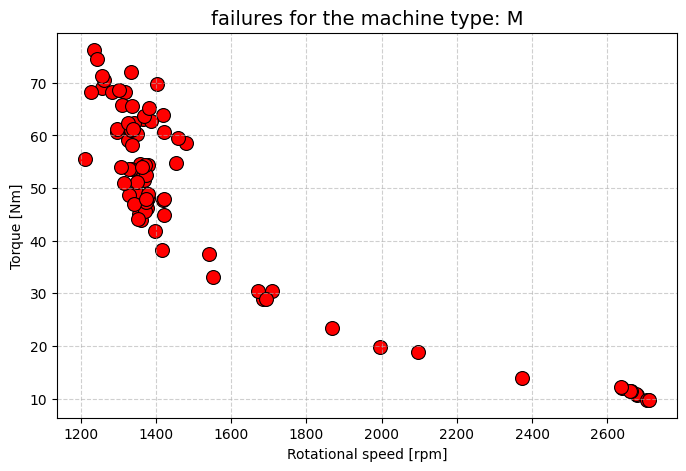

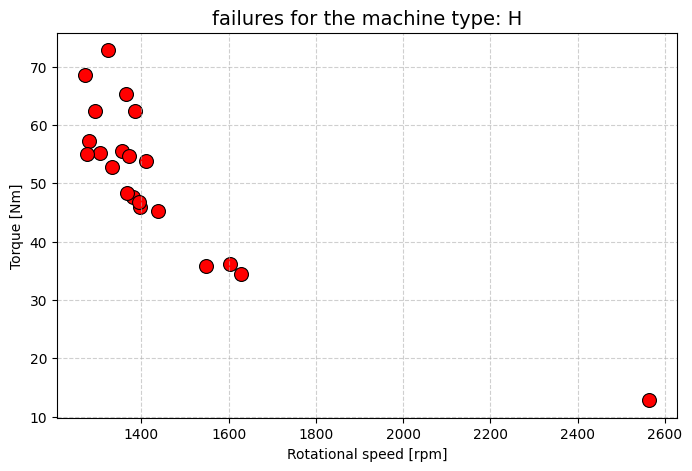

In [6]:
# filter only the failures 
failures = data[data['Machine failure'] == 1]

# Check the unique types for each machine (L, M, H)
machine_types = failures['Type'].unique()

# Loop to print every type in a different plot
for m_type in machine_types:
    # filter the specific failure for the particular type
    subset = failures[failures['Type'] == m_type]
    
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=subset, 
        x="Rotational speed [rpm]", 
        y="Torque [Nm]", 
        color="red", 
        s=100, 
        edgecolor="black"
    )
    
    plt.title(f"failures for the machine type: {m_type}", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

C:\Users\pkiaz\AppData\Local\Temp\ipykernel_29604\20563658.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Machine failure", y="Torque [Nm]", data=data, palette="coolwarm")


<Figure size 800x600 with 0 Axes>

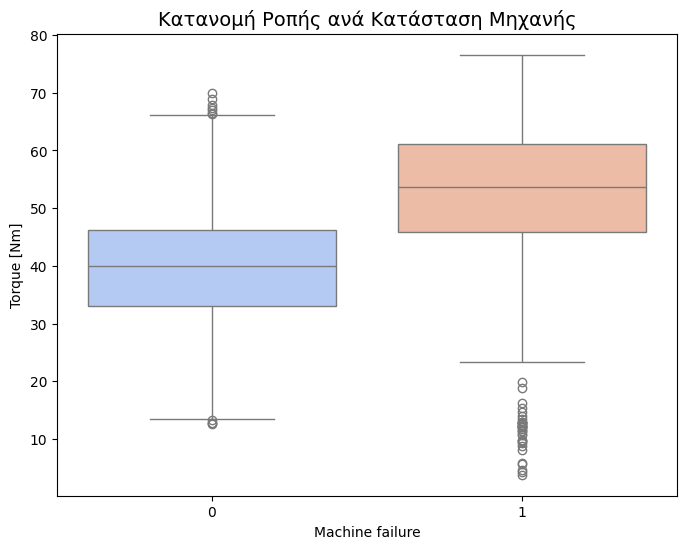

In [7]:
# Torque Comparison for Failures vs Non-Failures with Boxplot
plt.figure(figsize=(8, 6))
plt.figure(figsize=(8, 6))
sns.boxplot(x="Machine failure", y="Torque [Nm]", data=data, palette="coolwarm")
plt.title("Κατανομή Ροπής ανά Κατάσταση Μηχανής", fontsize=14)
plt.savefig("torque_boxplot.png")

### Torque Distribution Analysis
In the following boxplot, we observe that **Torque** is a significant feature for our analysis. There is a clear distinction between functional machines and those that experienced a failure:

* **Functional Machines (0):** The torque normally moves around **40 Nm**.
* **Broken Machines (1):** These show significantly **increased Nm** levels in comparison with the functional ones.

---

### Failure Mode Definitions
Now we proceed into analyzing the specific failure features. Each failure type represents a different operational issue:

* **TWF (Tool Wear Failure):** The machine failed due to excessive wear on the tool.
* **HDF (Heat Dissipation Failure):** Failure caused by poor heat dissipation (overheating).
* **PWF (Power Failure):** Failure related to the power output (the relationship between torque and speed).
* **OSF (Overstrain Failure):** Failure due to excessive load or physical strain.
* **RNF (Random Failures):** Random failures that are not easily predicted by standard measurements.

In [8]:
failure_modes = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = data[failure_modes].sum().sort_values(ascending=False)
print(failure_counts)

HDF    115
OSF     98
PWF     95
TWF     46
RNF     19
dtype: int64


C:\Users\pkiaz\AppData\Local\Temp\ipykernel_29604\3788289684.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=failure_counts.index, y=failure_counts.values, palette="viridis")


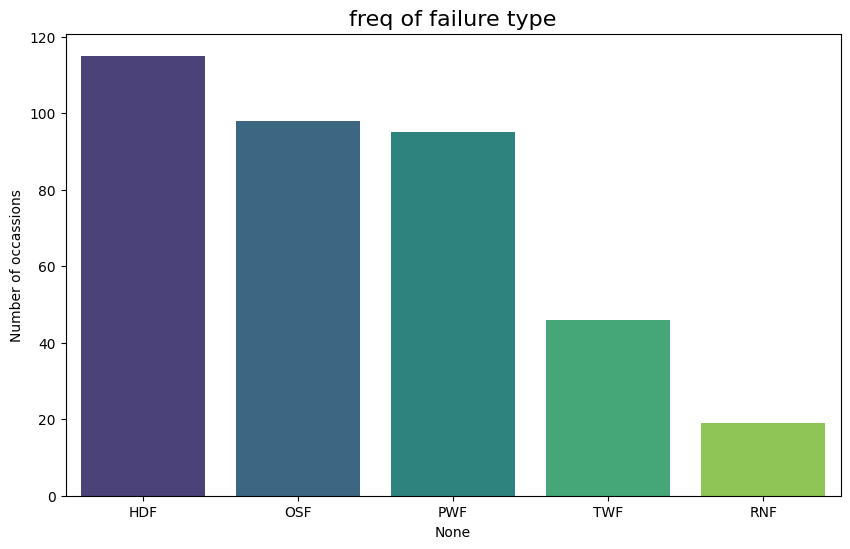

In [9]:
plt.figure(figsize=(10, 6))
sns.barplot(x=failure_counts.index, y=failure_counts.values, palette="viridis")
plt.title("freq of failure type", fontsize=16)
plt.ylabel("Number of occassions")
plt.show()

from a first look we can hypothesize thta RNF is an outlier feature.We apply also a heatmap to checjk the correlation between those contributions.  

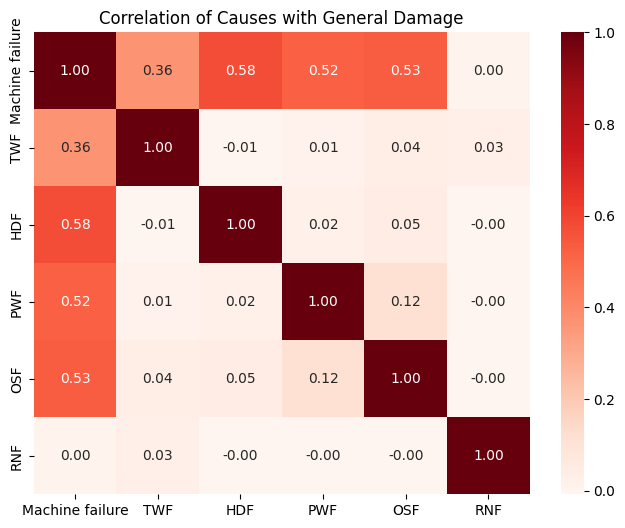

In [10]:
cols_to_check = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

plt.figure(figsize=(8, 6))
sns.heatmap(data[cols_to_check].corr(), annot=True, cmap="Reds", fmt=".2f")
plt.title("Correlation of Causes with General Damage")
plt.show()

## Correlation Analysis Findings

The evidence is clear! Based on the heatmap, we can observe the following correlations with **Machine failure**:

* **HDF (0.58):** Heat Dissipation Failure is the primary cause of breakdown.
* **OSF (0.53) & PWF (0.52):** These two failure modes (**Overstrain** and **Power Failure**) are directly related to **Torque**.

> **Key Observation:** Since Torque and Rotational Speed are inversely related, when torque is very high (meaning speeds **< 1400 rpm**), the **OSF** and **PWF** indicators reach critical levels ("hit the red").

---

In [11]:
# We calculate how many faults each row has.
data['Total_Failures'] = data[failure_modes].sum(axis=1)

# We only show cases that have more than 1 cause of failure
multi_failure = data[data['Total_Failures'] > 1]
print(f"found {len(multi_failure)} cases with multiple causes of damage.")


features = ['Torque [Nm]', 'Rotational speed [rpm]', 'Tool wear [min]', 'Process temperature [K]']
X = data[features]

found 24 cases with multiple causes of damage.


Because there are only 24 cases in a dataset of thousands of rows, they are too few to negatively affect our model.
## Machine Learning Baseline: Logistic Regression

To transition from EDA to prediction, we establish a **Baseline Model** using **Logistic Regression**. The goal is to determine if we can predict a `Machine failure` based on the operational stressors identified during our analysis.

### Selected Features
Based on our Correlation Analysis and Scatter Plots, we will use the following key drivers:
* **Torque [Nm]:** The primary indicator of mechanical stress.
* **Rotational Speed [rpm]:** Inversely related to torque and a key factor in power failures.
* **Temperature Difference:** Calculated as `Process temperature [K]` - `Air temperature [K]` to represent thermal strain.

### Methodology
1.  **Feature Engineering:** Create a `Temp_Diff` column.
2.  **Data Scaling:** Apply `StandardScaler` to ensure all features are on the same scale (essential for Logistic Regression).
3.  **Handling Imbalance:** Use `class_weight='balanced'` to account for the rare occurrence of failures.
4.  **Evaluation:** Use a **Confusion Matrix** and **Recall** to see how many actual failures the model can detect.

---

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt 

--- Logistic Regression Baseline Results ---
Accuracy Score: 0.8270

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      1932
           1       0.15      0.84      0.25        68

    accuracy                           0.83      2000
   macro avg       0.57      0.83      0.58      2000
weighted avg       0.96      0.83      0.88      2000



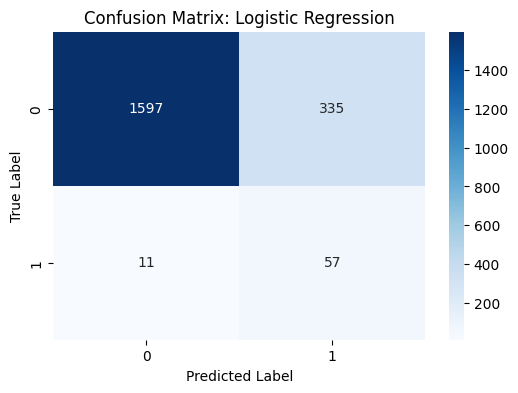


--- Feature Importance (Coefficients) ---
                  Feature    Weight
0             Torque [Nm]  2.413217
1  Rotational speed [rpm]  1.746118
2         Tool wear [min]  0.963192
3               Temp_Diff -0.946157


In [13]:
# Select features that our EDA showed are important
# We include Torque, RPM, Tool wear, and Temperature difference
data['Temp_Diff'] = data['Process temperature [K]'] - data['Air temperature [K]']
features = ['Torque [Nm]', 'Rotational speed [rpm]', 'Tool wear [min]', 'Temp_Diff']
X = data[features]
y = data['Machine failure']

# 2. Train/Test Split
# We use stratify because failures are rare (imbalanced data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

# 3. Scaling (Crucial for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Logistic Regression Model
model = LogisticRegression(class_weight='balanced') # 'balanced' helps with the rare failures
model.fit(X_train_scaled, y_train)

# 5. Predictions and Evaluation
y_pred = model.predict(X_test_scaled)

print("--- Logistic Regression Baseline Results ---")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 6. Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 7. Feature Importance (Weights)
importance = pd.DataFrame({'Feature': features, 'Weight': model.coef_[0]})
importance = importance.sort_values(by='Weight', ascending=False)
print("\n--- Feature Importance (Coefficients) ---")
print(importance)

##  Model Evaluation: Interpretation of Results

After training our **Logistic Regression Baseline**, we analyzed the model's behavior through two primary lenses: **Feature Importance** and the **Confusion Matrix**.

### 1. Feature Importance (Why the model predicts a failure)
The coefficients reveal which operational factors have the strongest "weight" in triggering a failure prediction:

* **Torque [Nm] (Weight: 2.42):** By far the most dominant factor. The model confirms our EDA: high torque is the primary "red flag" for a breakdown.
* **Rotational speed [rpm] (Weight: 1.73):** The second most critical driver. The model uses speed in conjunction with torque to define the machine's stress boundaries.
* **Tool wear [min] (Weight: 0.87):** A significant but secondary factor, representing the gradual degradation of components over time.
* **Temp_Diff (Weight: -0.90):** The negative weight suggests that while temperature difference is important, its information is partially redundant (correlated) with Torque, and the model adjusts its influence accordingly.

### 2. Confusion Matrix & Metrics (How well the model performs)
The matrix allows us to see the trade-off between catching failures and making mistakes:

* **Recall (0.82):** **Success!** The model successfully identifies **82% of all actual failures**. In Predictive Maintenance, this is our top priority because missing a failure (False Negative) is the costliest mistake.
* **Precision (0.14):** This low score highlights a high number of **False Alarms (False Positives)**. The model is currently "playing it safe" by alerting us to many potential issues that don't end up being failures.
* **Accuracy (0.82):** While decent, it is less important than Recall in this specific imbalanced scenario.

###  Final Verdict
The baseline is **highly effective at identifying risk** but is **too sensitive**, leading to unnecessary maintenance checks. 

**Next Steps for Improvement:**
* Experiment with non-linear models like **Random Forest** or **XGBoost** to better capture the complex "curved" relationship between Torque and Speed.
* Fine-tune the classification threshold to reduce False Alarms without sacrificing too much Recall.

# XGBoost algorythm and machine learning approach

here we will tryu to apply XGBoost (non-linear model) where it builds decision trees sequentially with each tree attempting to correct the mistakes made by the previous one

In [14]:
# Αφαιρούμε τις αγκύλες και τα κενά από τα ονόματα των στηλών
data.columns = data.columns.str.replace('[', '', regex=False).str.replace(']', '', regex=False).str.replace(' ', '_', regex=False)

# 2. Ορισμός των νέων ονομάτων στη λίστα features
# Πλέον το 'Torque [Nm]' έγινε 'Torque_Nm' κτλ.
features = ['Torque_Nm', 'Rotational_speed_rpm', 'Tool_wear_min', 'Temp_Diff']

X = data[features]
y = data['Machine_failure']

# 3. Τώρα το Split θα δουλέψει χωρίς σφάλματα
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

C:\Users\pkiaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\training.py:183: UserWarning: [14:18:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- XGBoost Results ---
Accuracy Score: 0.9875

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.84      0.78      0.81        68

    accuracy                           0.99      2000
   macro avg       0.92      0.89      0.90      2000
weighted avg       0.99      0.99      0.99      2000



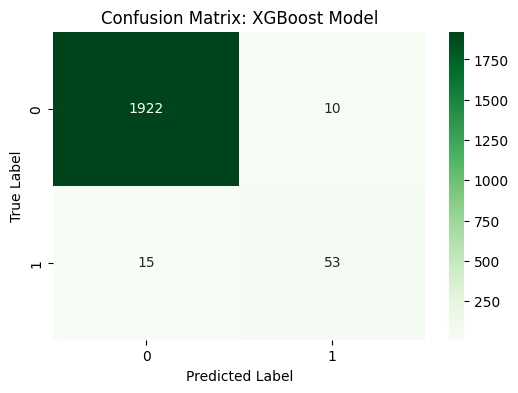

In [26]:
from xgboost import XGBClassifier

X = data[features]
y = data['Machine_failure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Calculate Scale Weight for Imbalanced Data
# ratio = negative_cases / positive_cases
ratio = float(y_train.value_counts()[0] / y_train.value_counts()[1])

xbgm_model = XGBClassifier(
    n_estimators=100, 
    max_depth=4, 
    learning_rate=0.1, 
    scale_pos_weight=ratio * 0.05, # Critical for imbalanced failure data
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xbgm_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xbgm_model.predict(X_test)


# Evaluation
print("--- XGBoost Results ---")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))


# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix: XGBoost Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

##  Final Model Evaluation: The Power of XGBoost

By transitioning from a linear Baseline (Logistic Regression) to a tree-based ensemble method (**XGBoost**), and carefully tuning the class weights, we achieved a highly effective Predictive Maintenance model.

###  The Ratio Optimization
The primary challenge in predicting machine failure is dealing with highly imbalanced data (failures are very rare). 
By applying a calculated `scale_pos_weight` multiplier of **0.05**, we instructed the model to strike the perfect balance between sensitivity (catching failures) and precision (avoiding false alarms).

###  Performance Breakthrough
The confusion matrix and classification report demonstrate an outstanding improvement:

* **Precision (0.84):** A massive leap from our baseline. When this model triggers a "Failure Alert", it is correct **84%** of the time. This means the factory avoids the costly downtime associated with unnecessary maintenance checks (False Alarms dropped drastically to just 10 cases).
* **Recall (0.78):** The model still successfully identifies **78%** of all actual failures (True Positives = 53). While slightly lower than the baseline, it is a calculated and highly profitable trade-off for the massive gain in Precision.
* **F1-Score (0.81):** This harmonic mean of Precision and Recall proves we have found the "sweet spot" for industrial application.
* **Overall Accuracy (0.99):** The model correctly predicts the machine's state 99% of the time across the entire test set.

###  Conclusion
The XGBoost model, utilizing only **Torque, Rotational Speed, Tool Wear, and Temperature Difference**, successfully decodes the complex, non-linear physical stressors of the machinery. It is robust, highly precise, and ready for deployment to optimize factory maintenance schedules.